In [ ]:
# This Colab provide all implementations for comapre baseline and HorusEye.

In [ ]:
pip install ksvd

In [ ]:
pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 13.7 MB/s eta 0:00:00


In [ ]:
import sys
import os

from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    denoise_nl_means,
    estimate_sigma,
)
from bm3d import bm3d, BM3DProfile
from sklearn.feature_extraction import image
from ksvd import ApproximateKSVD
import cv2
import numpy as np
from sklearn import linear_model
import scipy.misc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt

/tmp/ipython-input-1002139369.py:17: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/HorusEye/example_data/fig_2_4.npy'
img = np.load(file_path)

Mounted at /content/drive


In [ ]:
def plot_parallel(height=3, cmap="gray", clim=(None, None), v_low=0, v_high=0, pad=0.5,
                  show_axis=False, show_title=False, show_bar=False, show=True,
                  **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        v = np.array(v, "float32")
        if cmap != "gray":
            pcm = ax.imshow(v, vmax=v_high, cmap=cmap)
        elif v_high != v_low:
            pcm = ax.imshow(v, cmap=cmap, clim=clim, vmin=v_low, vmax=v_high)
        else:
            pcm = ax.imshow(v, cmap=cmap, clim=clim)

        if not show_axis:
            ax.axis("off")
        if show_title:
            ax.set_title(k)
        if show_bar:
            fig.colorbar(pcm, ax=ax)

    fig.tight_layout()
    if show:
        plt.tight_layout(w_pad=pad)
        plt.show()
    else:
        fig.tight_layout(w_pad=pad)

In [ ]:
def denoise_tv_img(img, weight=0.001):
    de = denoise_tv_chambolle(img[np.newaxis], weight=weight, channel_axis=0)
    return de[0]

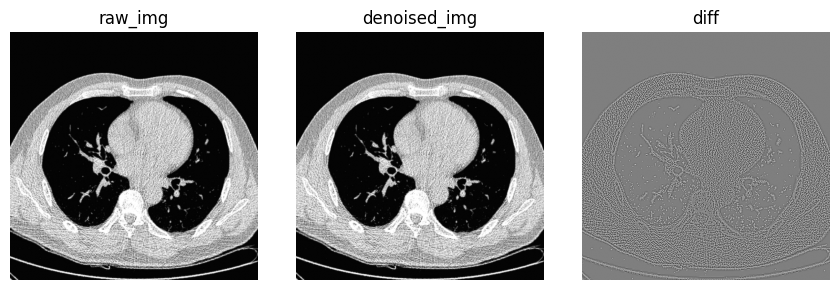

In [ ]:
de_tv = denoise_tv_img(img)
diff = img - de_tv
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_tv,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)

In [ ]:
def denoise_ksvd_img(img, patch_size=(5, 5), n_components=32, n_nonzero=5):
    patches = image.extract_patches_2d(img, patch_size)
    signals = patches.reshape(patches.shape[0], -1).astype(np.float32)
    mean = np.mean(signals, axis=1)[:, np.newaxis]
    signals -= mean

    aksvd = ApproximateKSVD(n_components=n_components, transform_n_nonzero_coefs=n_nonzero)
    subset = signals[np.random.choice(len(signals), min(1000, len(signals)), replace=False)]
    dictionary = aksvd.fit(subset).components_

    gamma = aksvd.transform(signals)
    reduced = gamma.dot(dictionary) + mean
    reduced_img = image.reconstruct_from_patches_2d(reduced.reshape(patches.shape), img.shape)

    return reduced_img

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:216: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:216: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:216: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:216: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested pr

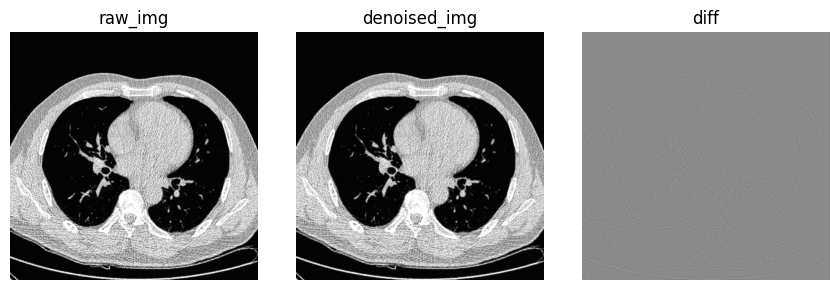

In [ ]:
de_ksvd = denoise_ksvd_img(img)
diff = img - de_ksvd
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_ksvd,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)

In [ ]:
def denoise_bm3d_img(img, std):
    return bm3d(img, sigma_psd=std)

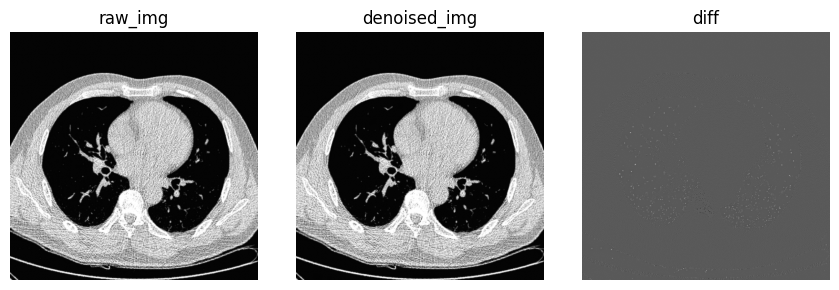

In [ ]:
de_bm3d = denoise_bm3d_img(img, std=np.std(img - de_ksvd))
diff = img - de_bm3d
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_bm3d,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)

In [ ]:
from torch.optim.lr_scheduler import StepLR

class ZS_N2N(nn.Module):
    def __init__(self, n_channels=1, embed_channels=48):
        super(ZS_N2N, self).__init__()
        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.conv1 = nn.Conv2d(n_channels, embed_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(embed_channels, embed_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(embed_channels, n_channels, kernel_size=1)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return self.conv3(x)

    def _pair_downsampler(self, img):
        # Input shape: (B, C, H, W)
        c = img.shape[1]
        f1 = torch.tensor([[[[0, 0.5], [0.5, 0]]]], dtype=img.dtype, device=img.device).repeat(c, 1, 1, 1)
        f2 = torch.tensor([[[[0.5, 0], [0, 0.5]]]], dtype=img.dtype, device=img.device).repeat(c, 1, 1, 1)
        out1 = F.conv2d(img, f1, stride=2, groups=c)
        out2 = F.conv2d(img, f2, stride=2, groups=c)
        return out1, out2

    def _mse(self, x, y):
        return F.mse_loss(x, y)

    def compute_loss(self, noisy_img):
        # Residual prediction loss
        noisy1, noisy2 = self._pair_downsampler(noisy_img)
        pred1 = noisy1 - self(noisy1)
        pred2 = noisy2 - self(noisy2)
        loss_res = 0.5 * (self._mse(noisy1, pred2) + self._mse(noisy2, pred1))

        # Consistency loss
        denoised = noisy_img - self(noisy_img)
        denoised1, denoised2 = self._pair_downsampler(denoised)
        loss_cons = 0.5 * (self._mse(pred1, denoised1) + self._mse(pred2, denoised2))

        return loss_res + loss_cons

    def train_step(self, optimizer, noisy_img):
        self.train()
        loss = self.compute_loss(noisy_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()


def denoise_ZSN2N_img(img):
    img = np.clip(img, 0, 1)
    img = torch.tensor(img[np.newaxis, np.newaxis], dtype=torch.float32).cuda()

    # Initialize model
    model = ZS_N2N(n_channels=1).cuda()

    # Training settings
    max_epoch = 1000
    lr = 0.001
    step_size = 1000
    gamma = 0.5

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Training loop
    for epoch in range(max_epoch):
        model.train_step(optimizer, img)
        scheduler.step()

    # Inference
    model.eval()
    with torch.no_grad():
        denoised = img - model(img)

    return denoised.cpu().numpy()[0, 0]

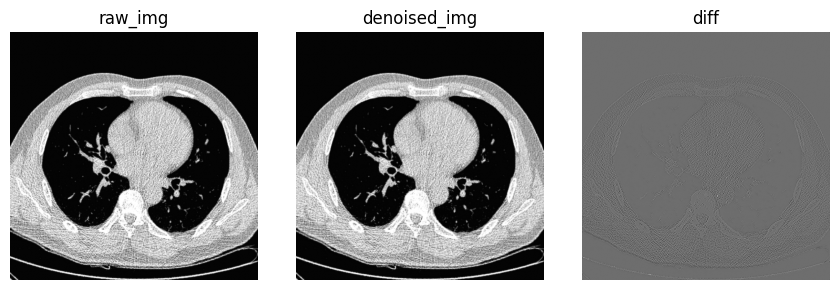

In [ ]:
de_zsn2n = denoise_ZSN2N_img(img)
diff = img - de_zsn2n
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_zsn2n,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/HorusEye/'
sys.path.append(base_path)

from DIP.utils.common_utils import get_noise, get_image, np_to_torch
from DIP.models.skip import skip

def denoise_DIP_img(img, num_iter=3000, lr=0.001, input_depth=32):
    img_np = np.array(img, "float32")
    img_torch = np_to_torch(img_np)[None].cuda()

    net = skip(input_depth, img_torch.shape[1],
               num_channels_down=[128, 128, 128, 128],
               num_channels_up=[128, 128, 128, 128],
               num_channels_skip=[4, 4, 4, 4],
               upsample_mode='bilinear').cuda()
    # net.apply(lambda m: m.weight.data.normal_())

    noise = get_noise(input_depth, 'noise', img_np.shape).cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

    for i in range(num_iter):
        optimizer.zero_grad()
        out = net(noise)
        loss = torch.nn.functional.mse_loss(out, img_torch)
        loss.backward()
        optimizer.step()
        scheduler.step()

    out_np = out.detach().cpu().numpy()[0, 0]
    return np.clip(out_np, 0, 1)

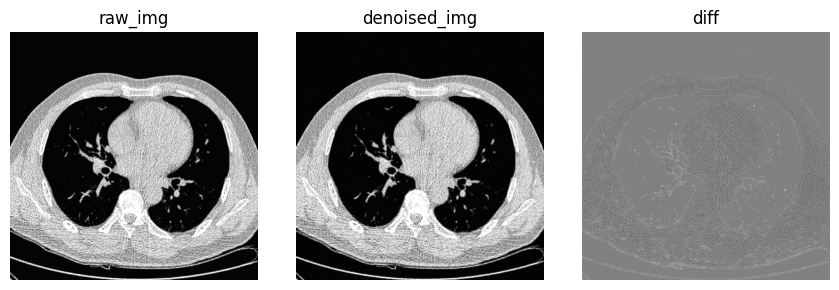

In [ ]:
de_dip = denoise_DIP_img(img)
diff = img - de_dip
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_dip,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)

In [ ]:
class RED_CNN(nn.Module):
    def __init__(self, in_chans=1, out_ch=96, final_chans=1):
        super(RED_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_chans, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)

        self.tconv1 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv2 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv3 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv4 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv5 = nn.ConvTranspose2d(out_ch, final_chans, kernel_size=5, stride=1, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        residual_1 = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        residual_2 = out
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        residual_3 = out
        out = self.relu(self.conv5(out))
        # decoder
        out = self.tconv1(out)
        out += residual_3
        out = self.tconv2(self.relu(out))
        out = self.tconv3(self.relu(out))
        out += residual_2
        out = self.tconv4(self.relu(out))
        out = self.tconv5(self.relu(out))
        out += residual_1
        out = self.relu(out)
        return out

def denoise_RED(img):
    img = np.clip((img * 1600) / (3000 + 1000), 0, 1)
    model = RED_CNN().to('cuda')
    model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/HorusEye/RED_CNN.pth'))
    model.half()
    model.eval()

    input_img = torch.tensor(img[np.newaxis, np.newaxis, :]).to(torch.float).to('cuda').half()
    pre = model(input_img)

    denoised = pre.cpu().detach().numpy()[0, 0]
    return denoised * 4000 / 1600

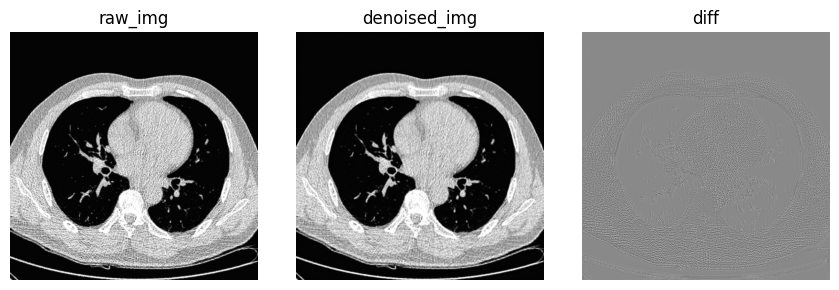

In [ ]:
de_red = denoise_RED(img)
diff = img - de_red
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_red,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/HorusEye/'
sys.path.append(base_path)

from CT_former.model import CTformer

def denoise_former(img, rescale=True):
    def split_arr(arr, patch_size, stride=32):  ## 512*512 to 32*32
        pad = (16, 16, 16, 16)  # pad by (0, 1), (2, 1), and (3, 3)
        arr = nn.functional.pad(arr, pad, "constant", 0)
        _, _, h, w = arr.shape
        num = h // stride - 1
        arrs = torch.zeros(num * num, 1, patch_size, patch_size)

        for i in range(num):
            for j in range(num):
                arrs[i * num + j, 0] = arr[0, 0, i * stride:i * stride + patch_size, j * stride:j * stride + patch_size]
        return arrs

    def agg_arr(arrs, size, stride=32):  ## from 32*32 to size 512*512
        arr = torch.zeros(size, size)
        n, _, h, w = arrs.shape
        num = size // stride
        for i in range(num):
            for j in range(num):
                arr[i * stride:(i + 1) * stride, j * stride:(j + 1) * stride] = arrs[i * num + j, :, 16:48, 16:48]

        return arr.unsqueeze(0).unsqueeze(1)

    if rescale:
      img = np.clip((img * 1600) / (3000 + 1000), 0, 1)

    img = torch.tensor(img[np.newaxis, np.newaxis, :]).to(torch.float).cuda()
    denoise_model = CTformer(img_size=64, tokens_type='performer', embed_dim=64, depth=1, num_heads=8, kernel=4,
                             stride=4, mlp_ratio=2., token_dim=64)
    denoise_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/HorusEye/CTFormer.ckpt"))
    denoise_model = denoise_model.cuda()
    denoise_model = denoise_model.to('cuda')

    arrs = split_arr(img, 64).cuda()  ## split to image patches for test into 4 patches
    arrs[0:64] = denoise_model(arrs[0:64])
    arrs[64:2 * 64] = denoise_model(arrs[64:2 * 64])
    arrs[2 * 64:3 * 64] = denoise_model(arrs[2 * 64:3 * 64])
    arrs[3 * 64:4 * 64] = denoise_model(arrs[3 * 64:4 * 64])
    prediction = agg_arr(arrs, 512).cuda()

    if rescale:
      prediction = prediction * 4000 / 1600

    return prediction.cpu().detach().numpy()[0, 0]

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


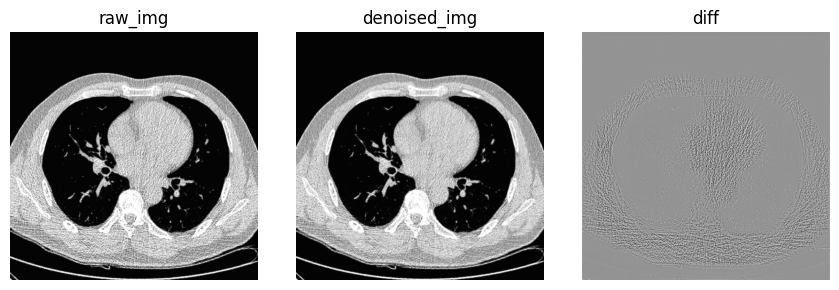

In [ ]:
de_former = denoise_former(img)
diff = img - de_former
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
plot_parallel(
    raw_img=img,
    denoised_img=de_former,
    diff=diff,
    show_title=True,
    v_high=1, v_low=0
)